# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (urti), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [3]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [4]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [5]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [6]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [7]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'hx_hosp', 'CCI', 'died_date', 'deregistered_date',  #'meds_nonabs', 
                   'gp_count_'+str(i), 'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date',
                           'gp_count_'+str(i): 'gp_count', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [ ]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate', 'count']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [ ]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+roc_name, bbox_inches='tight')
    plt.show()

In [ ]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [ ]:
def cph_output(cph, data_train, data_test, event_name, duration_name, directory, output_name):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+output_name, "w")
    a.write("")
    a.writelines(['Concordance index for urti_no_abs_incdt with training data: %.4f' % (concord_index_train), 
                '\nConcordance index for urti_no_abs_incdt with testing data: %.4f' % (concord_index_test)])

## 1- Data Preparation

In [8]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
# data_bmi = pd.read_csv(f'../output/hospitalisation_data/input_bmi.csv.gz')

data.shape

(200000, 225)

In [9]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/data_urti_record_cph_urti.txt", "w")
a.write("")
a.writelines(['data_urti_1 #with a record, #with no record: %.0f' % (data['urti_date_1'].notna().sum()), ', %.0f' % (data['urti_date_1'].isna().sum()),
              '\ndata_urti_2 #with a record, #with no record: %.0f' % (data['urti_date_2'].notna().sum()), ', %.0f' % (data['urti_date_2'].isna().sum()),
              '\ndata_urti_3 #with a record, #with no record: %.0f' % (data['urti_date_3'].notna().sum()), ', %.0f' % (data['urti_date_3'].isna().sum()),
              '\ndata_urti_4 #with a record, #with no record: %.0f' % (data['urti_date_4'].notna().sum()), ', %.0f' % (data['urti_date_4'].isna().sum()),
              '\ndata_urti_5 #with a record, #with no record: %.0f' % (data['urti_date_5'].notna().sum()), ', %.0f' % (data['urti_date_5'].isna().sum()),
              '\ndata_urti_6 #with a record, #with no record: %.0f' % (data['urti_date_6'].notna().sum()), ', %.0f' % (data['urti_date_6'].isna().sum()),
              '\ndata_urti_7 #with a record, #with no record: %.0f' % (data['urti_date_7'].notna().sum()), ', %.0f' % (data['urti_date_7'].isna().sum()),
              '\ndata_urti_8 #with a record, #with no record: %.0f' % (data['urti_date_8'].notna().sum()), ', %.0f' % (data['urti_date_8'].isna().sum()),
              '\ndata_urti_9 #with a record, #with no record: %.0f' % (data['urti_date_9'].notna().sum()), ', %.0f' % (data['urti_date_9'].isna().sum()),
              '\ndata_urti_10 #with a record, #with no record: %.0f' % (data['urti_date_10'].notna().sum()), ', %.0f' % (data['urti_date_10'].isna().sum()),
              '\ndata_urti_11 #with a record, #with no record: %.0f' % (data['urti_date_11'].notna().sum()), ', %.0f' % (data['urti_date_11'].isna().sum()),
              '\ndata_urti_12 #with a record, #with no record: %.0f' % (data['urti_date_12'].notna().sum()), ', %.0f' % (data['urti_date_12'].isna().sum()),
              '\ndata_urti_13 #with a record, #with no record: %.0f' % (data['urti_date_13'].notna().sum()), ', %.0f' % (data['urti_date_13'].isna().sum()),
              '\ndata_urti_14 #with a record, #with no record: %.0f' % (data['urti_date_14'].notna().sum()), ', %.0f' % (data['urti_date_14'].isna().sum()),
              '\ndata_urti_15 #with a record, #with no record: %.0f' % (data['urti_date_15'].notna().sum()), ', %.0f' % (data['urti_date_15'].isna().sum()),
              '\ndata_urti_16 #with a record, #with no record: %.0f' % (data['urti_date_16'].notna().sum()), ', %.0f' % (data['urti_date_16'].isna().sum()),
              '\ndata_urti_17 #with a record, #with no record: %.0f' % (data['urti_date_17'].notna().sum()), ', %.0f' % (data['urti_date_17'].isna().sum()),
              '\ndata_urti_18 #with a record, #with no record: %.0f' % (data['urti_date_18'].notna().sum()), ', %.0f' % (data['urti_date_18'].isna().sum()),
              ])

In [10]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,sgss_gp_cov_urti_date_16,sgss_gp_cov_urti_date_17,sgss_gp_cov_urti_date_18,sgss_gp_cov_urti_date_19,sgss_gp_cov_urti_date_20,urti_ab_count_1,urti_ab_count_2,urti_ab_count_3,urti_ab_count_4,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1343,754,45,45,45,13,13,1344,1344,1344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-09-06,2022-08-25,2022-01,2021-04,2021-06,2018-08,2018-05,2019-08-30,2021-04-27,2021-02-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,17,164,3570,505,499,1789,1728,77,29,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.901640,0.898215,0.900625,0.899420,9.994127e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,1.862343,1.855530,1.860324,1.858182,5.782935e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+01
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.992610e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.986640e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500812e+06


### 1-2- Additional variables
#### 1-2-1- Calculating Charlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [11]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37135
1.0     36983
2.0     33096
3.0     24688
4.0     14858
6.0     12272
7.0      9987
5.0      8471
8.0      7911
9.0      5790
10.0     3435
11.0     1840
12.0     1388
13.0      830
14.0      537
15.0      357
16.0      203
17.0      121
18.0       58
19.0       30
20.0        5
21.0        3
22.0        2
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [12]:
# #generate meds_noabs in the one month before
# data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# # assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
# data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

# data['meds_nonabs'].value_counts()
# # data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

## 2- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- Gathering data

In [13]:
#read 12 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(215992, 20)

### 2-2- Add season, event, and duration variables
#### Season

In [14]:
# convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] #gp_cons_urti
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')
data_urti.shape

(215992, 21)

In [15]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get 2 months before today's date in year and month 
last_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_month_date_y_m = last_month_date_y_m.strftime('%Y-%m')
#drop any record of data with 1 month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

data_urti['season'].value_counts()

spring    59164
summer    53996
winter    52975
autumn    43927
Name: season, dtype: int64

In [16]:
# data_urti = data_urti[data_urti['date'] <= '2019-12']
# data_urti = data_urti[(data_urti['date'] >= '2020-03') & (data_urti['date']<= '2021-03')]
# data_urti = data_urti[data_urti['date'] >= '2021-04']
data_urti.shape

(210062, 23)

#### Adding event and duration columns

In [17]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    147003
Name: event_urti_admitted, dtype: int64

In [18]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days #gp_cons_urti
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
# data_urti['event_urti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

117.0     68
73.0      64
160.0     62
38.0      59
88.0      59
          ..
1287.0     1
1307.0     1
1269.0     1
1304.0     1
1323.0     1
Name: delta_urti_admitted, Length: 1316, dtype: int64

In [19]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

176304

In [20]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    178055
1.0      1471
Name: event_urti_admitted, dtype: int64

In [21]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    178082
21.0        58
27.0        56
28.0        55
25.0        54
14.0        53
2.0         52
8.0         52
17.0        52
18.0        52
4.0         51
16.0        51
6.0         51
12.0        50
10.0        49
22.0        48
20.0        48
29.0        46
24.0        46
0.0         46
9.0         46
15.0        45
1.0         44
11.0        44
19.0        44
3.0         44
5.0         43
23.0        43
13.0        42
7.0         40
26.0        39
Name: duration_urti_admitted, dtype: int64

In [22]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    178047
1.0      1479
Name: event_urti_admitted, dtype: int64

In [23]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [24]:
# data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
205802,1.0,1.0
181881,1.0,1.0
189062,1.0,1.0
99334,1.0,1.0
89464,1.0,1.0
...,...,...
72172,0.0,30.0
72173,0.0,30.0
72174,0.0,30.0
72163,0.0,30.0


### 2-3- Dealing with uninteresting and missing values

In [25]:
# prep before plot
data_urti['age'][data_urti['age'] < 0] = np.nan
# drop anybody with age less than 18
data_urti = data_urti[~(data_urti['age'] < 18)]  
print(f'Min age: {data_urti.age.min()}')

## remove died cases
#data_urti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
# replace 0s with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})

# remove cases with negative gp_count
data_urti['gp_count'][data_urti['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [26]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [27]:
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_urti['region_imp'] = data_urti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_urti.region.isnull().sum()}')
    data_urti = data_urti[data_urti['region'].notna()]

print(f'Cound of missing values in variable region: {data_urti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_urti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      28428
East                        14246
North West                  14243
South East                  14160
South West                  14154
Yorkshire and The Humber    14070
North East                  14040
West Midlands               13984
East Midlands               13867
Name: region, dtype: int64


In [28]:
if ('gp_count' in data_urti.columns) and (data_urti['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_urti.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_urti.gp_count.mean():.3f}')
    data_urti['gp_count'] = data_urti['gp_count'].fillna(0)
    # data_urti['gp_count'] = data_urti['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_urti.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_urti.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 839
Mean of gp_count values before changing NAN to zeros: 3.343

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.324


In [29]:
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_urti.antibacterial_brit.mean():.3f}')
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)
    # data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_urti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 2
Mean of antibacterial_brit values before changing NAN to zeros: 1.258

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.258


In [30]:
# if ('meds_nonabs' in data_urti.columns) and (data_urti['meds_nonabs'].isnull().sum() > 0):
#     print(f'Cound of missing values in variable meds_nonabs before changing NANs to zeros: {data_urti.meds_nonabs.isnull().sum()}')
#     print(f'Mean of meds_nonabs values before changing NAN to zeros: {data_urti.meds_nonabs.mean():.3f}')
#     data_urti['meds_nonabs'] = data_urti['meds_nonabs'].fillna(0)
#     # data_urti['meds_nonabs'] = data_urti['meds_nonabs'].replace({'0':np.nan, 0:np.nan})

# print(f'\nCound of missing values in variable meds_nonabs after changing NANs to zeros: {data_urti.meds_nonabs.isnull().sum()}')
# print(f'Mean of meds_nonabs values after changing NANs to zeros: {data_urti.meds_nonabs.mean():.3f}')

In [31]:
if ('hx_hosp' in data_urti.columns) and (data_urti['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_urti.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_urti.hx_hosp.mean():.3f}')
    data_urti['hx_hosp'] = data_urti['hx_hosp'].fillna(0)
    # data_urti['hx_hosp'] = data_urti['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_urti.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_urti.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.453


In [32]:
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_urti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_urti.ethnicity.value_counts()}')
    # data_urti['ethnicity'] = data_urti['ethnicity'].astype(str)
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_urti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_urti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 35210
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    84873
3.0    10573
5.0    10536
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    84873
0.0    35210
3.0    10573
5.0    10536
Name: ethnicity, dtype: int64


In [33]:
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_urti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_urti.smoking_status.value_counts()}')
    # data_urti['smoking_status'] = data_urti['smoking_status'].astype(str)
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_urti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_urti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 58302
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    54996
3.0    18383
2.0     9511
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    58302
1.0    54996
3.0    18383
2.0     9511
Name: smoking_status, dtype: int64


In [34]:
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_urti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_urti.imd.value_counts()}')
    # data_urti['imd'] = data_urti['imd'].astype(str)
    data_urti['imd'] = data_urti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_urti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_urti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
5    27327
4    26850
1    26744
3    26685
2    26589
0     6997
Name: imd, dtype: int64


In [35]:
# data_urti['bmi_cat'] = np.nan
data_urti['bmi_cat'] = 5
# data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
col_bmi_cat = data_urti.columns.get_loc('bmi_cat')

col_sex = data_urti.columns.get_loc('sex')
col_age = data_urti.columns.get_loc('age')
col_bmi = data_urti.columns.get_loc('bmi')

for idx, x in enumerate(data_urti['bmi_cat']):
    # if data_urti.iat[idx, col_age] >= 18: # 18 or older adults
    if data_urti.iat[idx, col_bmi] >= 30:
        data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_urti.iat[idx, col_bmi] >= 25) and (data_urti.iat[idx, col_bmi] < 30):
        data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_urti.iat[idx, col_bmi] >= 18.5) and (data_urti.iat[idx, col_bmi] < 25):
        data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_urti.iat[idx, col_bmi] < 18.5:
        data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #if data_urti.iat[idx, col_age] < 18: # drop anyone less than 18 year old children
    #     if data_urti.iat[idx, col_sex] == 0:
    #         for i in range(2, 18):         
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
    #                 data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
    #                 data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_urti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #     if data_urti.iat[idx, col_sex] == 1:
    #         for i in range(2, 18):         
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
    #                 data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
    #                 data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_urti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_urti.iat[idx, col_age] == 1: # 1 year old babies
    #     data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

data_urti['bmi_cat'].value_counts()

1    72987
5    35819
2    15958
3    11896
4     4532
Name: bmi_cat, dtype: int64

In [36]:
if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_urti.bmi_cat.value_counts()}')
    # data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_urti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    72987
5    35819
2    15958
3    11896
4     4532
Name: bmi_cat, dtype: int64


### 2-4- Translate values 

In [37]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
# dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
# dict_season = {'1':'spring', '2':'summer', '3':'autumn', '4': 'winter'}

In [38]:
# reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
# data_urti = data_urti.replace({"season": dict_season})

### 2-5- Categorising and assigning max value for continuous variables

In [39]:
# categorising
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,2,3,5,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_urti['CCI_cat'].value_counts()

very_high    37676
high         27919
very_low     26094
low          26023
medium       23480
Name: CCI_cat, dtype: int64

In [40]:
# assign max value to outliers (beyond 95 percentile)
data_urti['gp_count'].clip(0, data_urti['gp_count'].quantile(0.95), inplace=True)
# data_urti['gp_count'].max()

data_urti['gp_count_cat'] = pd.cut(data_urti['gp_count'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_urti['gp_count_cat'].value_counts()

low       78054
medium    31912
high      31226
Name: gp_count_cat, dtype: int64

In [41]:
# assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)
data_urti['antibacterial_brit'].max()

data_urti['antibacterial_brit_cat'] = pd.cut(data_urti['antibacterial_brit'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_urti['antibacterial_brit_cat'].value_counts()

low       81561
high      35590
medium    24041
Name: antibacterial_brit_cat, dtype: int64

In [42]:
# # assign max value to outliers (beyond 95 percentile)
# data_urti['meds_nonabs'].clip(0, data_urti['meds_nonabs'].quantile(0.95), inplace=True)
# data_urti['meds_nonabs'].max()

# data_urti['meds_nonabs_cat'] = pd.cut(data_urti['meds_nonabs'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
# data_urti['meds_nonabs_cat'].value_counts()

In [43]:
# assign max value to outliers (beyond 95 percentile)
data_urti['hx_hosp'].clip(0, data_urti['hx_hosp'].quantile(0.95), inplace=True)
data_urti['hx_hosp'].max()

data_urti['hx_hosp_cat'] = pd.cut(data_urti['hx_hosp'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_urti['hx_hosp_cat'].value_counts()

low       127029
high       11970
medium      2193
Name: hx_hosp_cat, dtype: int64

## 3- Plots

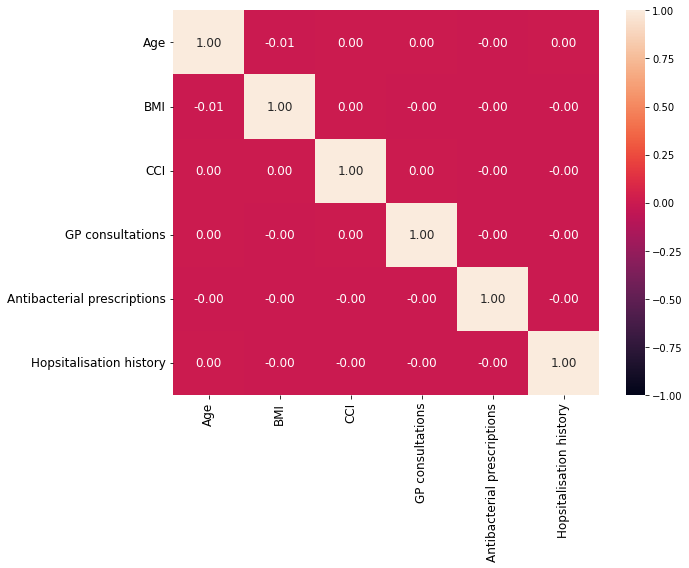

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'gp_count', 'antibacterial_brit', 'hx_hosp']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

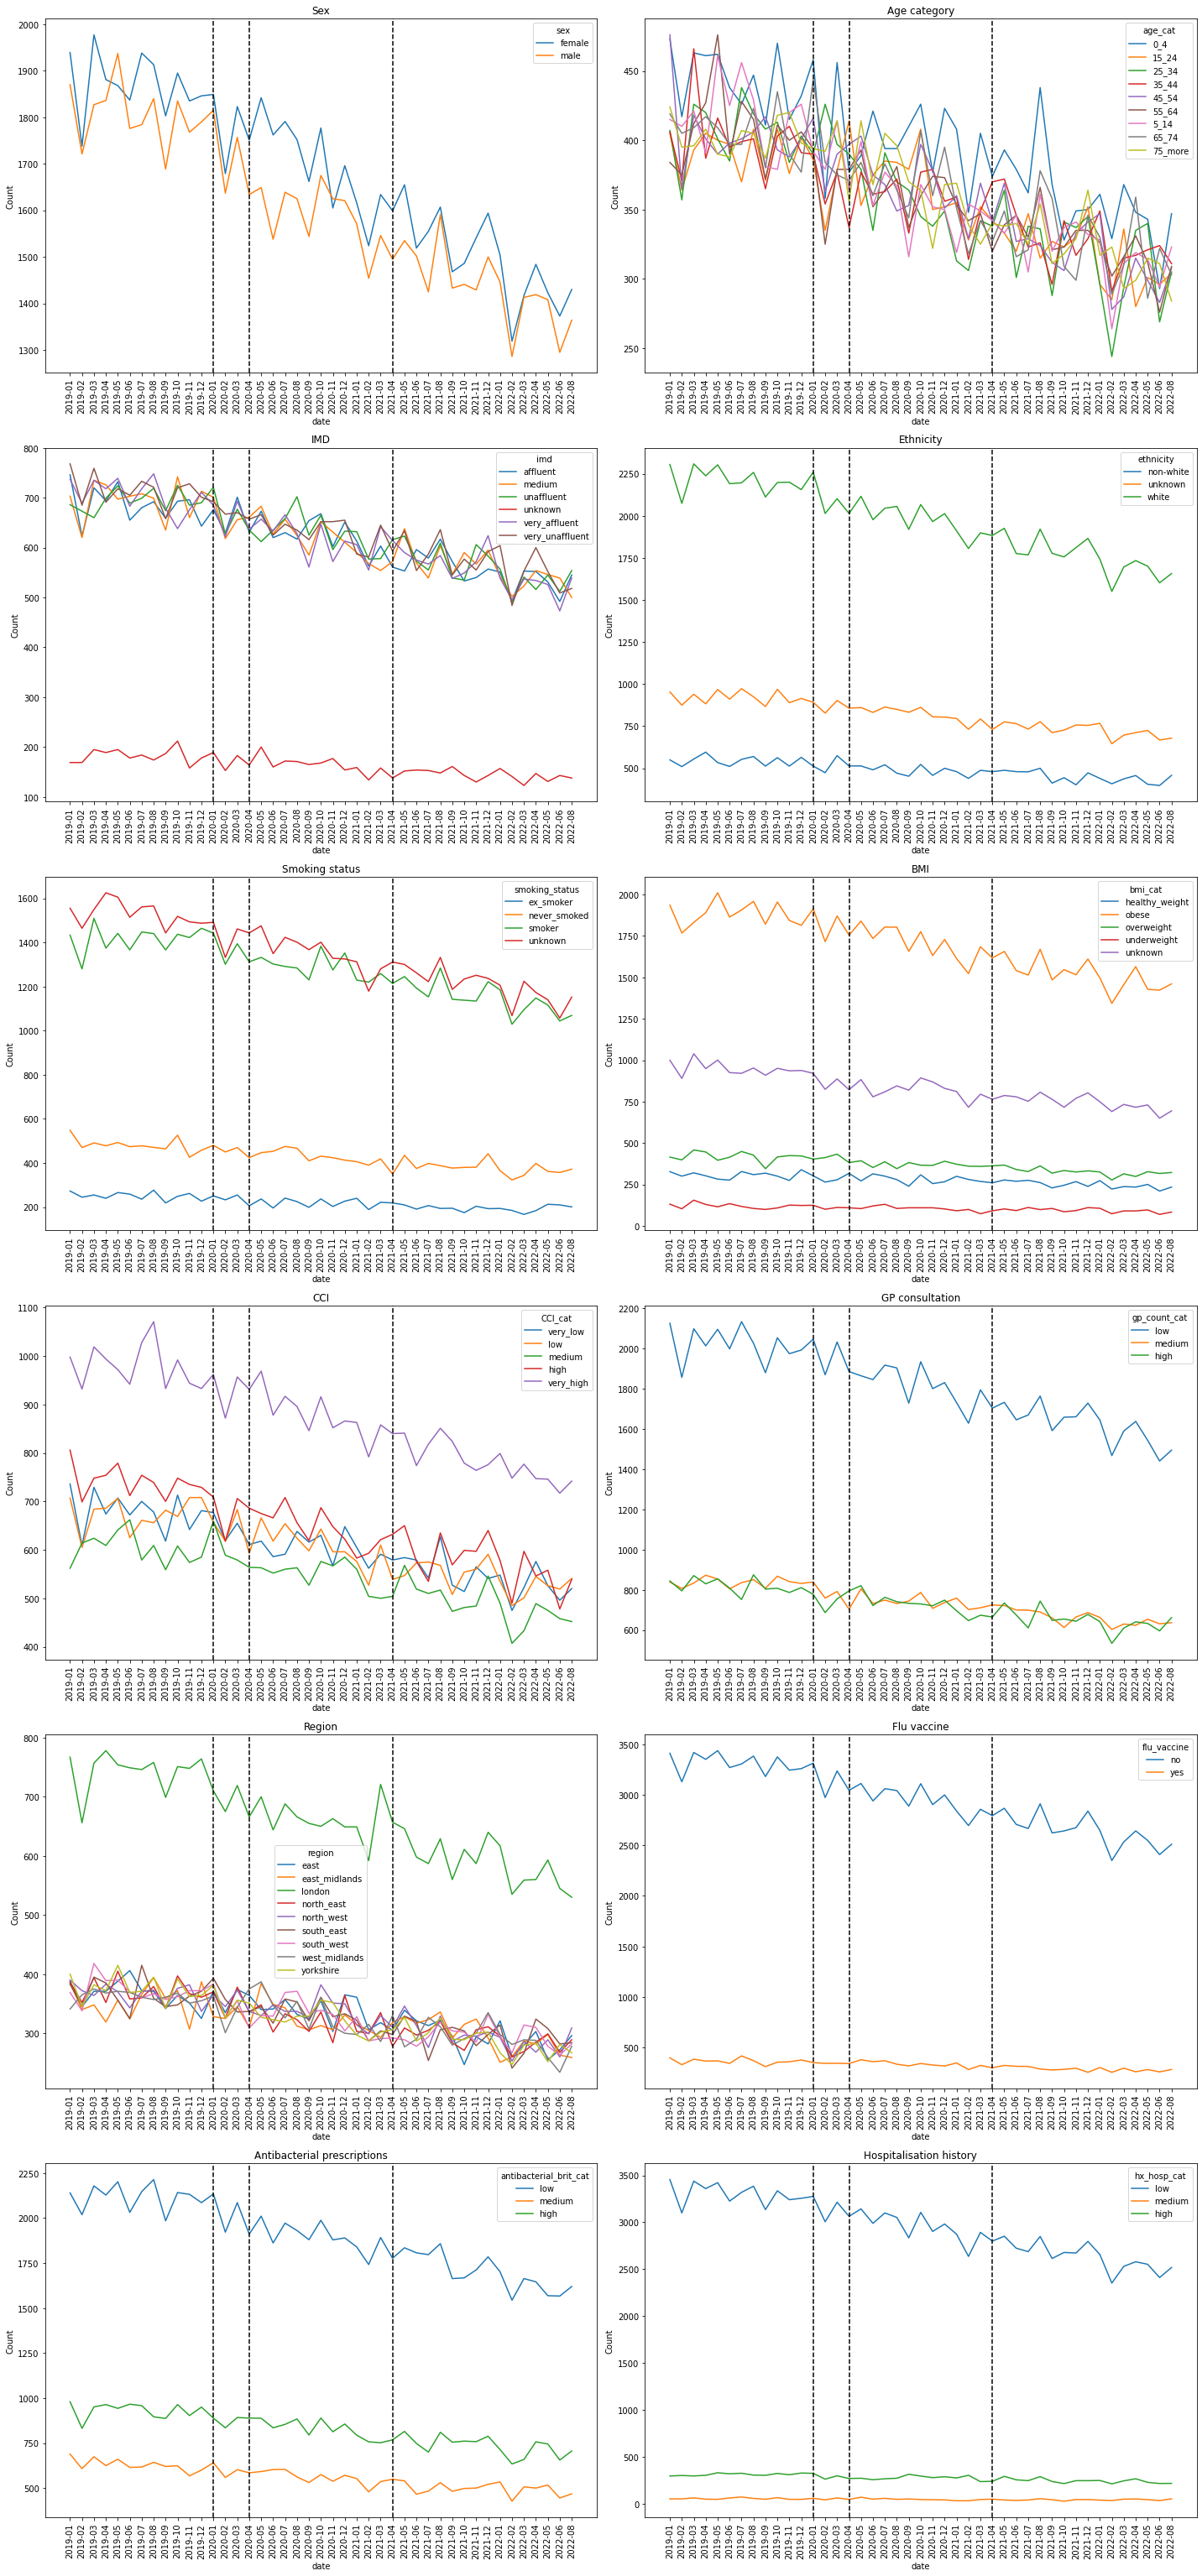

In [45]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_urti, 'gp_count_cat', 'GP consultation', axes[3,1])
create_lineplot(data_urti, 'region', 'Region', axes[4,0])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
create_lineplot(data_urti, 'hx_hosp_cat', 'Hospitalisation history', axes[5,1])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of urti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

## 4- Separate data of incident/prevalent and with/without antibiotics
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [46]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 
                        'smoking_status', 'season', #'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
                        'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                        'event_urti_admitted', 'duration_urti_admitted',
                        'urti_ab_date', 'incdt_urti_date',
                        'date']]

data_urti.shape

(141192, 17)

In [47]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['urti_ab_date'].isnull()] #gp_cons_urti_ab
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (114598, 17)
shape of data_urti_abs_incdt: (12500, 17)
shape of data_urti_no_abs_prevl: (12661, 17)
shape of data_urti_abs_prevl: (1433, 17)


In [48]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


In [49]:
print(f'shape of data_urti_no_abs_incdt: \n{data_urti_no_abs_incdt.event_urti_admitted.value_counts()}')
print(f'shape of data_urti_abs_incdt: \n{data_urti_abs_incdt.event_urti_admitted.value_counts()}')
print(f'shape of data_urti_no_abs_prevl: \n{data_urti_no_abs_prevl.event_urti_admitted.value_counts()}')
print(f'shape of data_urti_abs_prevl: \n{data_urti_abs_prevl.event_urti_admitted.value_counts()}')

shape of data_urti_no_abs_incdt: 
0.0    113666
1.0       932
Name: event_urti_admitted, dtype: int64
shape of data_urti_abs_incdt: 
0.0    12424
1.0       76
Name: event_urti_admitted, dtype: int64
shape of data_urti_no_abs_prevl: 
0.0    12578
1.0       83
Name: event_urti_admitted, dtype: int64
shape of data_urti_abs_prevl: 
0.0    1417
1.0      16
Name: event_urti_admitted, dtype: int64


In [66]:
# save data shape
a = open("../output/hospitalisation_prediction_urti/data_shape_cph_urti.txt", "w")
a.write("")
a.writelines(['data_urti_no_abs_incdt #observations, #events: %.0f' % (data_urti_no_abs_incdt.event_urti_admitted.value_counts()[0]), ', %.0f' % (data_urti_no_abs_incdt.event_urti_admitted.value_counts()[1]),
              '\ndata_urti_abs_incdt #observations, #events: %.0f' % (data_urti_abs_incdt.event_urti_admitted.value_counts()[0]), ', %.0f' % (data_urti_abs_incdt.event_urti_admitted.value_counts()[1]),
              '\ndata_urti_no_abs_prevl #observations, #events: %.0f' % (data_urti_no_abs_prevl.event_urti_admitted.value_counts()[0]), ', %.0f' % (data_urti_no_abs_prevl.event_urti_admitted.value_counts()[1]),
              '\ndata_urti_abs_prevl #observations, #events: %.0f' % (data_urti_abs_prevl.event_urti_admitted.value_counts()[0]), ', %.0f' % (data_urti_abs_prevl.event_urti_admitted.value_counts()[1])
              ])

## 5- Cox modelling for hospital admissions related to infections 
### 5-1- URTI
#### 5-1-1- Incident hospital admission related to URTI with no antibiotics

In [51]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season',
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', #'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_incdt.shape

(114598, 13)

In [52]:
# encoding categorical data for CPH
data = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_no_abs_incdt_enc = data[['antibacterial_brit']].join(data_urti_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_no_abs_incdt_enc.head()

,antibacterial_brit,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,age_cat_75_more,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [53]:
#summary table
summary_table_urti_no_abs_incdt = data_urti_no_abs_incdt_enc.sum(axis=0).reset_index()
summary_table_urti_no_abs_incdt.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_urti_no_abs_incdt['mean'] = data_urti_no_abs_incdt_enc.mean(axis=0).reset_index()[0]
summary_table_urti_no_abs_incdt['count'] = round_five_mul(summary_table_urti_no_abs_incdt['count'], base=5)
summary_table_urti_no_abs_incdt['std'] = data_urti_no_abs_incdt_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_urti_no_abs_incdt.loc[(summary_table_urti_no_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_urti_no_abs_incdt

# save table
summary_table_urti_no_abs_incdt.to_csv('../output/hospitalisation_prediction_urti/summary_table_urti_no_abs_incdt.csv', index=False)

In [54]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (85948, 13)
shape of data_urti_no_abs_incdt for testing: (28650, 13)


In [55]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"# + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_urti_no_abs_incdt.print_summary()

output = GetPrintSummary(cph_urti_no_abs_incdt)

#save model output
with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

<lifelines.CoxPHFitter: fitted with 85948 total observations, 85252 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 85948
number of events observed = 696
   partial log-likelihood = -7889.40
         time fit was run = 2022-09-12 08:34:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.12            -0.18             0.30                 0.84                 1.35
CCI_cat[T.medium]               -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
CCI_cat[T.high]                  0.03       1.03       0.12            -0.20             0.27                 0.82                 1.31
CCI_cat[T.very_high]            -0.10       0.90       0.12            -0.33             0.13                 0.72                 1.14
age_cat[T.15_24]                 0.12       1.13       0.16            -0.19             0.44                 0.83                 1.55
age_cat[T.25_34]                 0.24       1.27       0.16            -0.07             0.54                 0.93                 1.72
age_cat[T.35_44]                 0.11       1.12       0.16            -0.21             0.43                 0.81                 1.53
age_cat[T.45_54]                -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.31
age_cat[T.55_64]                -0.00       1.00       0.17            -0.33             0.32                 0.72                 1.38
age_cat[T.5_14]                  0.15       1.16       0.16            -0.17             0.46                 0.85                 1.59
age_cat[T.65_74]                 0.29       1.34       0.15            -0.01             0.59                 0.99                 1.81
age_cat[T.75_more]               0.02       1.02       0.17            -0.31             0.34                 0.74                 1.41
antibacterial_brit               0.02       1.02       0.03            -0.04             0.07                 0.96                 1.07
bmi_cat[T.obese]                 0.05       1.06       0.14            -0.23             0.34                 0.79                 1.40
bmi_cat[T.overweight]            0.18       1.19       0.17            -0.16             0.51                 0.85                 1.67
bmi_cat[T.underweight]           0.09       1.09       0.24            -0.39             0.57                 0.68                 1.76
bmi_cat[T.unknown]              -0.02       0.98       0.16            -0.33             0.28                 0.72                 1.33
ethnicity[T.unknown]            -0.17       0.84       0.12            -0.41             0.06                 0.66                 1.07
ethnicity[T.white]              -0.13       0.87       0.10            -0.34             0.07                 0.71                 1.07
flu_vaccine[T.yes]               0.19       1.22       0.12            -0.04             0.43                 0.96                 1.53
imd[T.medium]                    0.11       1.12       0.13            -0.14             0.36                 0.87                 1.44
imd[T.unaffluent]                0.20       1.23       0.13            -0.04             0.45                 0.96                 1.57
imd[T.unknown]                   0.09       1.09       0.20            -0.30             0.48                 0.74                 1.61
imd[T.very_affluent]             0.11       1.12       0.13            -0.14             0.36                 0.87                 1.44
imd[T.very_unaffluent]           0.26       1.30       0.12         

13309


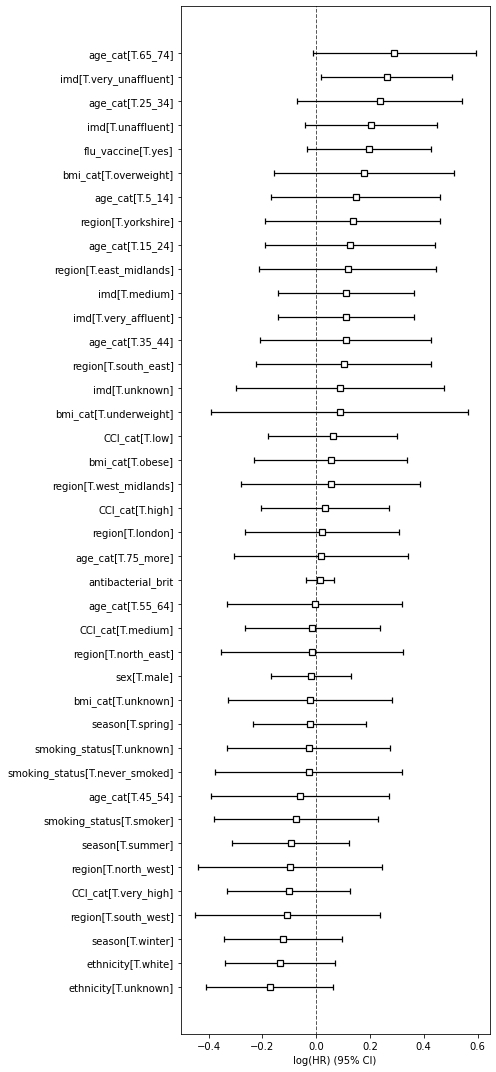

In [56]:
# # save betas of cph model
# # a = cph_urti_no_abs_incdt.baseline_hazard_
# a = cph_urti_no_abs_incdt.hazard_ratios_#.reset_index()
# a.to_csv('../output/hospitalisation_prediction_urti/betas_cph_urti_no_abs_incdt.csv')
# np.savetxt('../output/hospitalisation_prediction_urti/betas_cph_urti_no_abs_incdt.txt', a, delimiter=',')

# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_urti_no_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_urti_no_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_incdt.csv', data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt, 'sum_betas_cph_urti_no_abs_incdt.csv')

In [57]:
# # cleaning up covariates to make them compatible with the encoded data
# covariates = cph_urti_no_abs_incdt.params_.reset_index()#.hazard_ratios_
# covariates.covariate = covariates.covariate.str.replace("[","")
# covariates.covariate = covariates.covariate.str.replace("]","")
# covariates.covariate = covariates.covariate.str.replace("T.","_")
# # covariates.shape

# # save coefficients
# covariates.to_csv('../output/hospitalisation_prediction_urti/betas_cph_urti_no_abs_incdt.csv', index=False)

# # transpose and sort covariates and coefficients
# covariatesT = covariates.T
# # covariatesT.covariate = covariates
# header = covariatesT.iloc[0]
# covariatesT = covariatesT[1:]
# covariatesT.columns = header
# covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# # covariatesT.shape

# # further cleaning up covariates to make them compatible with the encoded data
# mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
# mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

# #match mylist (covariates of cox model) with encoded data
# data = data_urti_no_abs_incdt_enc[data_urti_no_abs_incdt_enc.columns.intersection(mylist)] 
# data = data.sort_index(axis = 1) #sort 
# # data.shape

# # multiply betas and encoded data
# betas = data.multiply(np.array(covariatesT), axis='columns')
# # betas

# # sum up betas of each row to calculate sum of betas 
# sum_betas = betas.sum(axis=1)
# # sum_betas

In [58]:
# # predict cumulative hazard values at day 30 and match them with sum of betas
# sum_betas_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt).loc[[30]].T.reset_index(drop=True)
# sum_betas_hazard['sum_betas'] = sum_betas
# # sum_betas_hazard

# # sort values of sum of betas
# sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# # sum_betas_hazard

# # binning sum of betas into 100 bins
# sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# # sum_betas_hazard

# #calculate mean of cumulative hazar at day 30 by groupby 
# sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# # sum_betas_hazard_groupby

# #calculate interpolation of missing mean values 
# sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# # separate upper and lower boundries of bins
# sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
# sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# # sum_betas_hazard_groupby.head()

# # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
# sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate', 'count']]

# # save relevant columns of sum_betas
# sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_incdt.csv', index=False)
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_incdt.txt', sum_betas, delimiter=',')

In [ ]:
#plot roc curve
cph_roc_curve(cph_urti_no_abs_incdt, 'event_urti_admitted', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_incdt.jpg')

In [63]:
# # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
# cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_train)
# cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.loc[[30]].T
# cph_urti_no_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_train['event_urti_admitted']
# cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# # cph_urti_no_abs_incdt_train_cumulative_hazard

# # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
# cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_test)
# cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.loc[[30]].T
# cph_urti_no_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_test['event_urti_admitted']
# cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# # cph_urti_no_abs_incdt_test_cumulative_hazard

# # plot roc curves
# r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
# r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# fig, ax1 = pyplot.subplots(figsize=(7, 7))
# line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
# line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

# squares = [0,1.01]
# plt.plot(squares,linewidth=1, color='grey')
# plt.ylim(0,1.01)
# plt.xlim(0,1)
# plt.xlabel('Specificity', fontsize=14)
# plt.ylabel('Sensitivity', fontsize=14)

# #reversing xticks
# xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
# x = np.arange(len(xticks))
# ax1.set(xticklabels=xticks)
# ax1.legend(fontsize=14)
# # plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15, rotation=0)
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# plot calibration plots with development and validation data
cph_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, 'event_urti_admitted', data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_incdt_train.jpg', 'calibration_cph_urti_no_abs_incdt_test.jpg')

In [60]:
# #predict cumulative hazard in day 30
# prob_pred_true_train = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_train).loc[[30]].T
# prob_pred_true_train.columns = ['pred']

# #group cumulative hazard into 10 bins with equal frequency of observations in each bin
# prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

# #merge cumulative hazards with their actual events (0, 1)
# prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_no_abs_incdt_train.event_urti_admitted, left_index=True, right_index=True)

# #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
# prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
# prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

# #calculate proportion of events in each bin
# prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# # prob_pred_true_train_groupby_bin


# #predict cumulative hazard in day 30
# prob_pred_true_test = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_test).loc[[30]].T
# prob_pred_true_test.columns = ['pred']

# #group cumulative hazard into 10 bins with equal frequency of observations in each bin
# prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

# #merge cumulative hazards with their actual events (0, 1)
# prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_no_abs_incdt_test.event_urti_admitted, left_index=True, right_index=True)

# #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
# prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
# prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

# #calculate proportion of events in each bin
# prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# # prob_pred_true_test_groupby_bin

In [64]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [65]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# calculate c-statistics
cph_output(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/', 'cph_urti_no_abs_incdt_output.txt')

In [63]:
# # calculate concordance index, AUROC, and Brier score of cph model
# concord_index_urti_no_abs_incdt_train = concordance_index(data_urti_no_abs_incdt_train['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_train), data_urti_no_abs_incdt_train['event_urti_admitted'])
# concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['event_urti_admitted'])
# r_auc1 = roc_auc_score(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
# r_auc2 = roc_auc_score(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
# brier1 = brier_score_loss(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
# brier2 = brier_score_loss(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# # save model outputs
# a = open("../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_output.txt", "w")
# a.write("")
# a.writelines(['Concordance index for urti_no_abs_incdt with testing data: %.4f' % (concord_index_urti_no_abs_incdt_test), 
#               '\nConcordance index for urti_no_abs_incdt with training data: %.4f' % (concord_index_urti_no_abs_incdt_train),
#               '\nAUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
#               '\nAUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
#               '\nBrier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
#               '\nBrier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

#### 5-1-2- Incident hospital admission related to URTI with antibiotics

In [76]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 
                                        #    'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 
                                           'antibacterial_brit', #'gp_count',  #'meds_nonabs', 'hx_hosp', 
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [77]:
# encoding categorical data for CPH
data = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_abs_incdt_enc = data[['antibacterial_brit']].join(data_urti_abs_incdt_enc) # , 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_abs_incdt_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
#summary table
summary_table_urti_abs_incdt = data_urti_abs_incdt_enc.sum(axis=0).reset_index()
summary_table_urti_abs_incdt.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_urti_abs_incdt['mean'] = data_urti_abs_incdt_enc.mean(axis=0).reset_index()[0]
summary_table_urti_abs_incdt['count'] = round_five_mul(summary_table_urti_abs_incdt['count'], base=5)
summary_table_urti_abs_incdt['std'] = data_urti_abs_incdt_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_urti_abs_incdt.loc[(summary_table_urti_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_urti_abs_incdt

# save table
summary_table_urti_abs_incdt.to_csv('../output/hospitalisation_prediction_urti/summary_table_urti_abs_incdt.csv', index=False)

In [78]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (338, 14)
shape of data_urti_abs_incdt for testing: (113, 14)


In [79]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"# + gp_count"# meds_nonabs + hx_hosp
        )
cph_urti_abs_incdt.print_summary()

#save model output
output = GetPrintSummary(cph_urti_abs_incdt)
with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

<lifelines.CoxPHFitter: fitted with 338 total observations, 336 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 338
number of events observed = 2
   partial log-likelihood = -0.69
         time fit was run = 2022-06-13 14:09:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -5.25       0.01   19912.90        -39033.83         39023.32                 0.00                  inf
CCI_cat[T.medium]               -1.99       0.14   20737.31        -40646.36         40642.38                 0.00                  inf
CCI_cat[T.high]                  0.39       1.48   19791.79        -38790.79         38791.58                 0.00                  inf
CCI_cat[T.very_high]             2.57      13.11   15541.17        -30457.57         30462.71                 0.00                  inf
age_cat[T.15_24]                 3.87      47.85   28739.48        -56324.49         56332.22                 0.00                  inf
age_cat[T.25_34]                11.01   60565.71   20299.85        -39775.97         39797.99                 0.00                  inf
age_cat[T.35_44]                -2.30       0.10   22732.68        -44557.55         44552.94                 0.00                  inf
age_cat[T.45_54]                 4.84     125.85   21212.30        -41570.52         41580.19                 0.00                  inf
age_cat[T.55_64]                 1.67       5.34   27782.27        -54450.58         54453.93                 0.00                  inf
age_cat[T.5_14]                 -2.16       0.12   23133.53        -45343.05         45338.74                 0.00                  inf
age_cat[T.65_74]                14.13   1.37e+06   15640.71        -30641.10         30669.36                 0.00                  inf
age_cat[T.75_more]               4.95     140.99   22338.33        -43777.36         43787.26                 0.00                  inf
antibacterial_brit               1.18       3.26    3193.09         -6257.16          6259.52                 0.00                  inf
bmi_cat[T.obese]                 0.64       1.90   27082.23        -53079.56         53080.84                 0.00                  inf
bmi_cat[T.overweight]           -1.95       0.14   30794.82        -60358.69         60354.79                 0.00                  inf
bmi_cat[T.underweight]          -5.99       0.00   38309.27        -75090.78         75078.80                 0.00                  inf
bmi_cat[T.unknown]              -3.66       0.03   28176.86        -55229.30         55221.98                 0.00                  inf
ethnicity[T.unknown]             3.55      34.84   17386.79        -34073.93         34081.03                 0.00                  inf
ethnicity[T.white]               8.04    3090.04   16680.81        -32685.75         32701.82                 0.00                  inf
flu_vaccine[T.yes]               0.01       1.01   22562.86        -44222.38         44222.39                 0.00                  inf
gp_count                        -0.47       0.63    2224.90         -4361.19          4360.25                 0.00                  inf
imd[T.medium]                   -1.87       0.15   17864.87        -35016.38         35012.64                 0.00                  inf
imd[T.unaffluent]                8.02    3046.19   12205.83        -23914.96         23931.00                 0.00                  inf
imd[T.unknown]                   6.87     962.22   41886.05        -82088.29         82102.03                 0.00                  inf
imd[T.very_affluent]            -0.08       0.92   20667.82        -40508.27   

14038


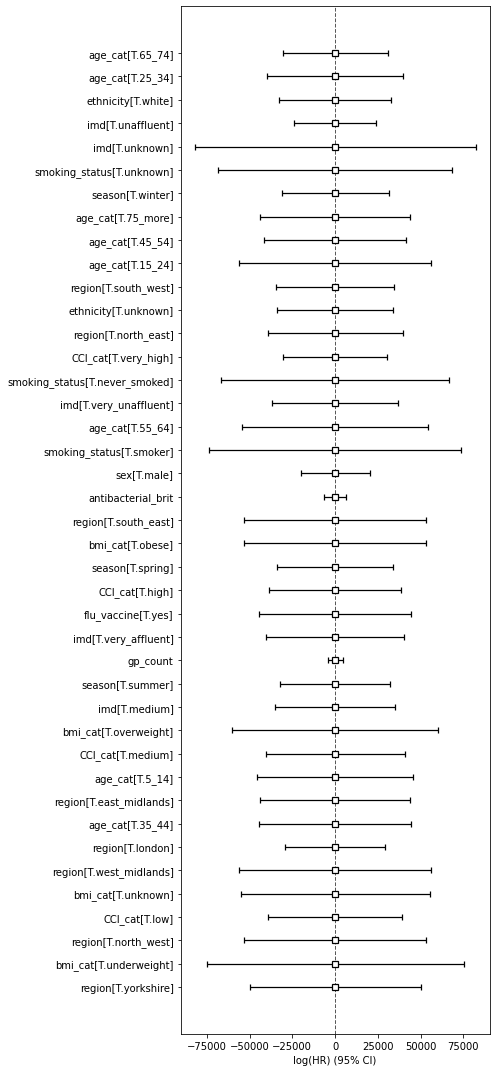

In [68]:
# # save betas of cph model
# a = cph_urti_abs_incdt.baseline_hazard_
# np.savetxt('../output/hospitalisation_prediction_urti/betas_cph_urti_abs_incdt.txt', a, delimiter=',')

# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_urti_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [69]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_urti_abs_incdt.params_.reset_index()#.hazard_ratios_
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_urti/betas_cph_urti_abs_incdt.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark

# match mylist (covariates of cox model) with encoded data
data = data_urti_abs_incdt_enc[data_urti_abs_incdt_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [70]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

# calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby.head()

# calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bin
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard 
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate', 'count']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_incdt.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_incdt.txt', sum_betas, delimiter=',')

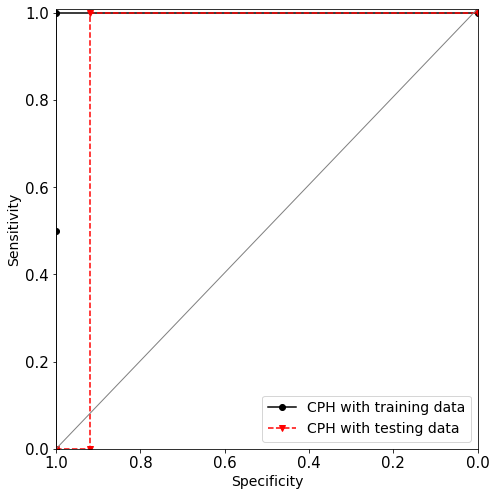

In [71]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_train)
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.loc[[30]].T
cph_urti_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_train['event_urti_admitted']
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_urti_abs_incdt_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_test)
cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.loc[[30]].T
cph_urti_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_test['event_urti_admitted']
cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_urti_abs_incdt_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_abs_incdt_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_abs_incdt_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [74]:
# calculate concordance index, AUROC, and Brier score of cph model 
concord_index_urti_abs_incdt_train = concordance_index(data_urti_abs_incdt_train['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_train), data_urti_abs_incdt_train['event_urti_admitted'])
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['event_urti_admitted'])
r_auc1 = roc_auc_score(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_abs_incdt with testing data: %.4f' % (concord_index_urti_abs_incdt_test), 
              '\nConcordance index for urti_abs_incdt with training data: %.4f' % (concord_index_urti_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

#### 5-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [186]:
#keep relevant variables
data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', #'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_prevl.shape

In [187]:
# encoding categorical data for CPH
data = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_no_abs_prevl_enc = data[['antibacterial_brit']].join(data_urti_no_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_no_abs_prevl_enc.head()

In [ ]:
#summary table
summary_table_urti_no_abs_prevl = data_urti_no_abs_prevl_enc.sum(axis=0).reset_index()
summary_table_urti_no_abs_prevl.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_urti_no_abs_prevl['mean'] = data_urti_no_abs_prevl_enc.mean(axis=0).reset_index()[0]
summary_table_urti_no_abs_prevl['count'] = round_five_mul(summary_table_urti_no_abs_prevl['count'], base=5)
summary_table_urti_no_abs_prevl['std'] = data_urti_no_abs_prevl_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_urti_no_abs_prevl.loc[(summary_table_urti_no_abs_prevl['count'] <= 5), 'count'] = 'SM'
# summary_table_urti_no_abs_prevl

# save table
summary_table_urti_no_abs_prevl.to_csv('../output/hospitalisation_prediction_urti/summary_table_urti_no_abs_prevl.csv', index=False)

In [188]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = train_test_split(data_urti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

In [189]:
cph_urti_no_abs_prevl = CoxPHFitter()
cph_urti_no_abs_prevl.fit(data_urti_no_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"# + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_urti_no_abs_prevl.print_summary()

#save model output
output = GetPrintSummary(cph_urti_no_abs_prevl)
with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [190]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [191]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_urti_no_abs_prevl.params_.reset_index()#.hazard_ratios_
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_urti/betas_cph_urti_no_abs_prevl.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

#match mylist (covariates of cox model) with encoded data
data = data_urti_no_abs_prevl_enc[data_urti_no_abs_prevl_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [192]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby

#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate', 'count']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_prevl.txt', sum_betas, delimiter=',')

In [193]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.loc[[30]].T
cph_urti_no_abs_prevl_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_train['event_urti_admitted']
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_urti_no_abs_prevl_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.loc[[30]].T
cph_urti_no_abs_prevl_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_test['event_urti_admitted']
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_urti_no_abs_prevl_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [194]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_no_abs_prevl_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_no_abs_prevl_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [195]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [197]:
# calculate concordance index, AUROC, and Brier score of cph model
concord_index_urti_no_abs_prevl_train = concordance_index(data_urti_no_abs_prevl_train['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_train), data_urti_no_abs_prevl_train['event_urti_admitted'])
concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['event_urti_admitted'])
r_auc1 = roc_auc_score(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_prevl with testing data: %.4f' % (concord_index_urti_no_abs_prevl_test), 
              '\nConcordance index for urti_no_abs_prevl with training data: %.4f' % (concord_index_urti_no_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])


#### 5-1-4- Prevalent hospital admission related to URTI with antibiotics

In [ ]:
#keep relevant variables
data_urti_abs_prevl = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', #'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

data_urti_abs_prevl.shape

In [ ]:
# encoding categorical data for CPH
data = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_abs_prevl_enc = data[['antibacterial_brit']].join(data_urti_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_abs_prevl_enc.head()

In [ ]:
#summary table
summary_table_urti_abs_prevl = data_urti_abs_prevl_enc.sum(axis=0).reset_index()
summary_table_urti_abs_prevl.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_urti_abs_prevl['mean'] = data_urti_abs_prevl_enc.mean(axis=0).reset_index()[0]
summary_table_urti_abs_prevl['count'] = round_five_mul(summary_table_urti_abs_prevl['count'], base=5)
summary_table_urti_abs_prevl['std'] = data_urti_abs_prevl_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_urti_abs_prevl.loc[(summary_table_urti_abs_prevl['count'] <= 5), 'count'] = 'SM'
# summary_table_urti_abs_prevl

# save table
summary_table_urti_abs_prevl.to_csv('../output/hospitalisation_prediction_urti/summary_table_urti_abs_prevl.csv', index=False)

In [ ]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_prevl_train, data_urti_abs_prevl_test = train_test_split(data_urti_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_prevl for training: {data_urti_abs_prevl_train.shape}')
print(f'shape of data_urti_abs_prevl for testing: {data_urti_abs_prevl_test.shape}')

In [ ]:
cph_urti_abs_prevl = CoxPHFitter()
cph_urti_abs_prevl.fit(data_urti_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"# + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_urti_no_abs_prevl.print_summary()

#save model output
output = GetPrintSummary(cph_urti_no_abs_prevl)
with open('../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [ ]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_urti_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_urti_abs_prevl.params_.reset_index()#.hazard_ratios_
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_urti/betas_cph_urti_abs_prevl.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

#match mylist (covariates of cox model) with encoded data
data = data_urti_abs_prevl_enc[data_urti_abs_prevl_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [ ]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_urti_abs_prevl.predict_cumulative_hazard(data_urti_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby

#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate', 'count']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_prevl.txt', sum_betas, delimiter=',')

In [ ]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_urti_abs_prevl_train_cumulative_hazard = cph_urti_abs_prevl.predict_cumulative_hazard(data_urti_abs_prevl_train)
cph_urti_abs_prevl_train_cumulative_hazard = cph_urti_abs_prevl_train_cumulative_hazard.loc[[30]].T
cph_urti_abs_prevl_train_cumulative_hazard['event_urti_admitted'] = data_urti_abs_prevl_train['event_urti_admitted']
cph_urti_abs_prevl_train_cumulative_hazard = cph_urti_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_urti_abs_prevl_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_urti_abs_prevl_test_cumulative_hazard = cph_urti_abs_prevl.predict_cumulative_hazard(data_urti_abs_prevl_test)
cph_urti_abs_prevl_test_cumulative_hazard = cph_urti_abs_prevl_test_cumulative_hazard.loc[[30]].T
cph_urti_abs_prevl_test_cumulative_hazard['event_urti_admitted'] = data_urti_abs_prevl_test['event_urti_admitted']
cph_urti_abs_prevl_test_cumulative_hazard = cph_urti_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_urti_abs_prevl_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_urti_abs_prevl.predict_cumulative_hazard(data_urti_abs_prevl_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_abs_prevl_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_urti_abs_prevl.predict_cumulative_hazard(data_urti_abs_prevl_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_abs_prevl_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# calculate concordance index, AUROC, and Brier score of cph model
concord_index_urti_abs_prevl_train = concordance_index(data_urti_abs_prevl_train['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_train), data_urti_abs_prevl_train['event_urti_admitted'])
concord_index_urti_abs_prevl_test = concordance_index(data_urti_abs_prevl_test['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_test), data_urti_abs_prevl_test['event_urti_admitted'])
r_auc1 = roc_auc_score(cph_urti_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_prevl_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_abs_prevl with testing data: %.4f' % (concord_index_urti_abs_prevl_test), 
              '\nConcordance index for urti_abs_prevl with training data: %.4f' % (concord_index_urti_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])


## 6- Logistic regression
### 6-1- URTI
#### 6-1-1- Incident hospital admission related to URTI with no antibiotics

In [198]:
# encoding categorical data for LR
data = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_no_abs_incdt_enc = data[['antibacterial_brit']].join(data_urti_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_no_abs_incdt_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_Unknown,ethnicity_White,smoking_status_Ex_smoker,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown,season_Autumn,season_Spring,season_Summer,season_Winter
0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [199]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_train, data_urti_no_abs_incdt_lr_y_test = train_test_split(data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt_lr_X for training: {data_urti_no_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_X for testing: {data_urti_no_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for training: {data_urti_no_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for testing: {data_urti_no_abs_incdt_lr_y_test.shape}')

shape of data_urti_no_abs_incdt_lr_X for training: (2948, 52)
shape of data_urti_no_abs_incdt_lr_X for testing: (983, 52)
shape of data_urti_no_abs_incdt_lr_y for training: (2948,)
shape of data_urti_no_abs_incdt_lr_y for testing: (983,)


In [200]:
#build LR model
lr_urti_no_abs_incdt = LogisticRegression().fit(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_incdt_train = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_train)
# pred_proba_urti_no_abs_incdt_train

#calculate score of lr_urti_no_abs_incdt with training data
lr_urti_no_abs_incdt_training_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)
print(f'score of lr_urti_no_abs_incdt with training data: {lr_urti_no_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_incdt_test = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_test)
# pred_proba_urti_no_abs_incdt_test

#calculate score of lr_urti_no_abs_incdt with testing data
lr_urti_no_abs_incdt_testing_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_test)
print(f'score of lr_urti_no_abs_incdt with testing data: {lr_urti_no_abs_incdt_testing_score}')


score of lr_urti_no_abs_incdt with training data: 0.9918588873812755
score of lr_urti_no_abs_incdt with testing data: 0.9959308240081384


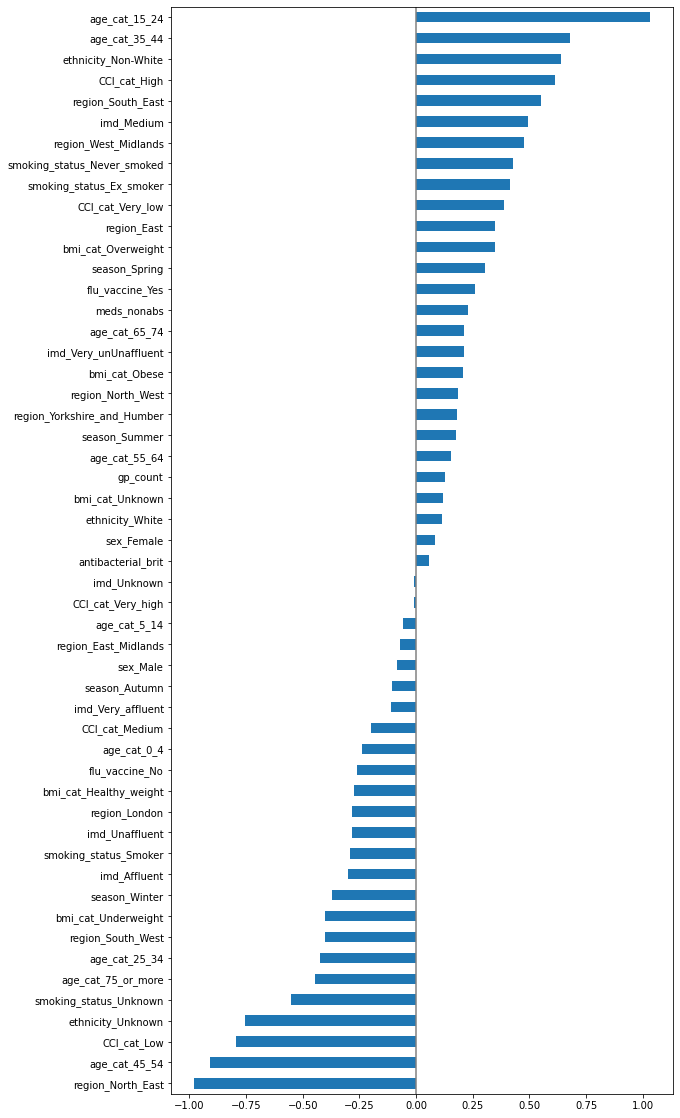

In [201]:
# set up coefficients of lr model
feature_names = lr_urti_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_incdt.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.csv', index=False)

# obtain intercept
interc = lr_urti_no_abs_incdt.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_incdt.txt', interc, delimiter=',')

# plot coefficients 
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

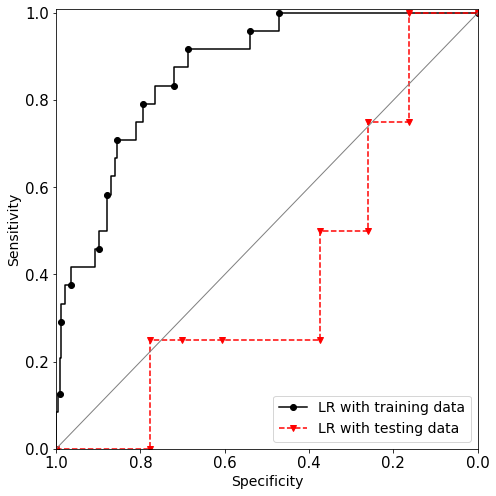

In [202]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_urti_no_abs_incdt_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_no_abs_incdt_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_urti_no_abs_incdt_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_no_abs_incdt_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [205]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

### 6-1-2- Incident hospital admission related to URTI with antibiotics

In [206]:
# encoding categorical data for LR
data = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_abs_incdt_enc = data[['antibacterial_brit']].join(data_urti_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_abs_incdt_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_Unknown,ethnicity_White,smoking_status_Ex_smoker,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown,season_Autumn,season_Spring,season_Summer,season_Winter
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [207]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_train, data_urti_abs_incdt_lr_y_test = train_test_split(data_urti_abs_incdt_enc, data_urti_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt_lr_X for training: {data_urti_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_X for testing: {data_urti_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for training: {data_urti_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for testing: {data_urti_abs_incdt_lr_y_test.shape}')

shape of data_urti_abs_incdt_lr_X for training: (329, 52)
shape of data_urti_abs_incdt_lr_X for testing: (110, 52)
shape of data_urti_abs_incdt_lr_y for training: (329,)
shape of data_urti_abs_incdt_lr_y for testing: (110,)


In [208]:
#build LR model
lr_urti_abs_incdt = LogisticRegression().fit(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_abs_incdt_train = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_train)
# pred_proba_urti_abs_incdt_train

#calculate score of lr_urti_abs_incdt with training data
lr_urti_abs_incdt_training_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)
print(f'score of lr_urti_abs_incdt with training data: {lr_urti_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_abs_incdt_test = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_test)
# pred_proba_urti_abs_incdt_test

#calculate score of lr_urti_abs_incdt with testing data
lr_urti_abs_incdt_testing_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_test)
print(f'score of lr_urti_abs_incdt with testing data: {lr_urti_abs_incdt_testing_score}')

score of lr_urti_abs_incdt with training data: 0.9969604863221885
score of lr_urti_abs_incdt with testing data: 0.990909090909091


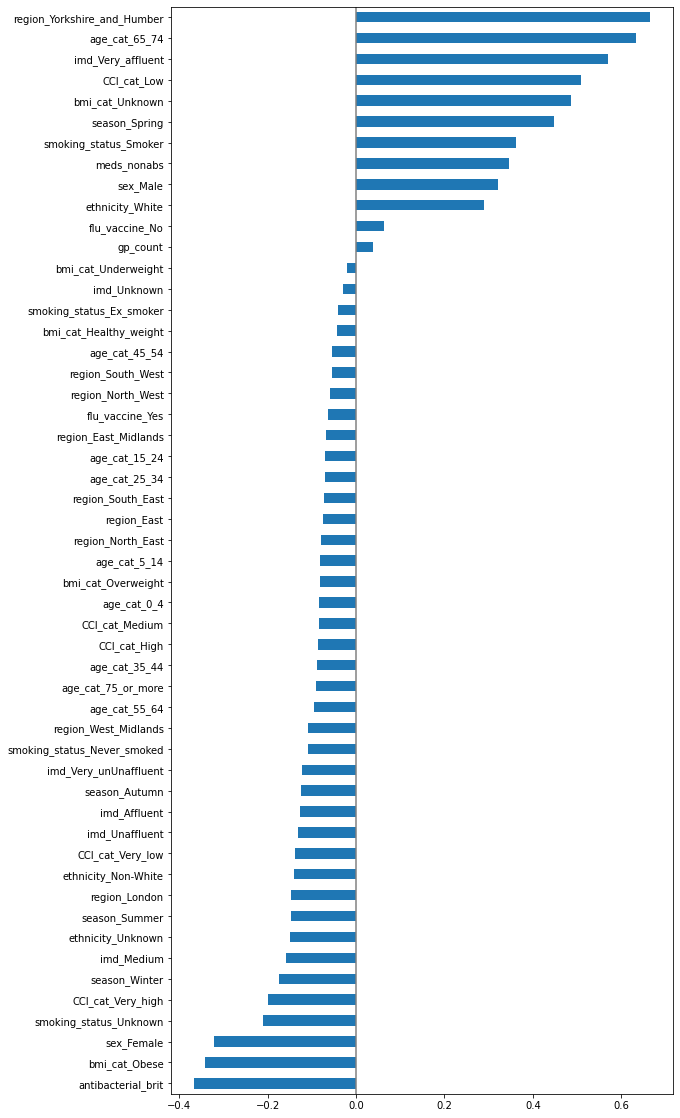

In [209]:
# set up coefficients of lr model
feature_names = lr_urti_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_abs_incdt.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.csv', index=False)

# obtain intercept
interc = lr_urti_abs_incdt.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_abs_incdt.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

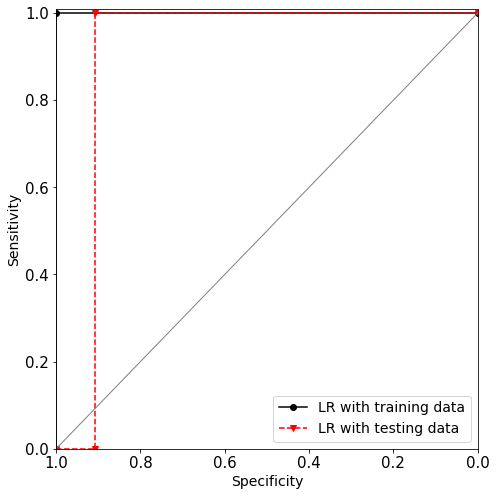

In [210]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_urti_abs_incdt_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_abs_incdt_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_urti_abs_incdt_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_abs_incdt_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [213]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

### 6-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [64]:
# encoding categorical data for LR
data = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_no_abs_prevl_enc = data[['antibacterial_brit']].join(data_urti_no_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_no_abs_prevl_enc.head()

In [65]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_train, data_urti_no_abs_prevl_lr_y_test = train_test_split(data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl_lr_X for training: {data_urti_no_abs_prevl_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_X for testing: {data_urti_no_abs_prevl_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for training: {data_urti_no_abs_prevl_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for testing: {data_urti_no_abs_prevl_lr_y_test.shape}')

In [66]:
#build LR model
lr_urti_no_abs_prevl = LogisticRegression().fit(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_prevl_train = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_train)
# pred_proba_urti_no_abs_prevl_train

#calculate score of lr_urti_no_abs_prevl with training data
lr_urti_no_abs_prevl_training_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)
print(f'score of lr_urti_no_abs_prevl with training data: {lr_urti_no_abs_prevl_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_prevl_test = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_test)
# pred_proba_urti_no_abs_prevl_test

#calculate score of lr_urti_no_abs_prevl with testing data
lr_urti_no_abs_prevl_testing_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_test)
print(f'score of lr_urti_no_abs_prevl with testing data: {lr_urti_no_abs_prevl_testing_score}')

In [67]:
# set up coefficients of lr model
feature_names = lr_urti_no_abs_prevl.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_prevl.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.csv', index=False)

# obtain intercept
interc = lr_urti_no_abs_prevl.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_prevl.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [68]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_urti_no_abs_prevl_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_no_abs_prevl_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_urti_no_abs_prevl_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_no_abs_prevl_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [221]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])

### 6-1-4- Prevalent hospital admission related to URTI with antibiotics

In [ ]:
# encoding categorical data for LR
data = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_urti_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_urti_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_urti_abs_prevl_enc = data[['antibacterial_brit']].join(data_urti_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_urti_admitted', 'duration_urti_admitted'

data_urti_abs_prevl_enc.head()

In [ ]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_prevl_lr_X_train, data_urti_abs_prevl_lr_X_test, data_urti_abs_prevl_lr_y_train, data_urti_abs_prevl_lr_y_test = train_test_split(data_urti_abs_prevl_enc, data_urti_abs_prevl.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_prevl_lr_X for training: {data_urti_abs_prevl_lr_X_train.shape}')
print(f'shape of data_urti_abs_prevl_lr_X for testing: {data_urti_abs_prevl_lr_X_test.shape}')
print(f'shape of data_urti_abs_prevl_lr_y for training: {data_urti_abs_prevl_lr_y_train.shape}')
print(f'shape of data_urti_abs_prevl_lr_y for testing: {data_urti_abs_prevl_lr_y_test.shape}')

In [ ]:
#build LR model
lr_urti_abs_prevl = LogisticRegression().fit(data_urti_abs_prevl_lr_X_train, data_urti_abs_prevl_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_abs_prevl_train = lr_urti_abs_prevl.predict_proba(data_urti_abs_prevl_lr_X_train)
# pred_proba_urti_abs_prevl_train

#calculate score of lr_urti_abs_prevl with training data
lr_urti_abs_prevl_training_score = lr_urti_abs_prevl.score(data_urti_abs_prevl_lr_X_train, data_urti_abs_prevl_lr_y_train)
print(f'score of lr_urti_abs_prevl with training data: {lr_urti_abs_prevl_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_abs_prevl_test = lr_urti_abs_prevl.predict_proba(data_urti_abs_prevl_lr_X_test)
# pred_proba_urti_abs_prevl_test

#calculate score of lr_urti_abs_prevl with testing data
lr_urti_abs_prevl_testing_score = lr_urti_abs_prevl.score(data_urti_abs_prevl_lr_X_test, data_urti_abs_prevl_lr_y_test)
print(f'score of lr_urti_abs_prevl with testing data: {lr_urti_abs_prevl_testing_score}')

In [ ]:
# set up coefficients of lr model
feature_names = lr_urti_abs_prevl.feature_names_in_
coef = np.squeeze(lr_urti_abs_prevl.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_prevl.csv', index=False)

# obtain intercept
interc = lr_urti_abs_prevl.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_abs_prevl.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for prevalent hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_abs_prevl_lr_y_train, pred_proba_urti_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_abs_prevl_lr_y_test, pred_proba_urti_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to prevalent \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_urti_abs_prevl_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_urti_abs_prevl_train.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_urti_abs_prevl_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_urti_abs_prevl_test.event_urti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_urti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_urti/calibration_lr_urti_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_urti_abs_prevl_lr_y_train, pred_proba_urti_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_urti_abs_prevl_lr_y_test, pred_proba_urti_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_urti_abs_prevl_lr_y_train, pred_proba_urti_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_urti_abs_prevl_lr_y_test, pred_proba_urti_abs_prevl_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent URTI with antibiotics = %.4f' % (brier2)])